# User Latent Dirichlet Allocation

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
sns.set_theme()
sys.path.append(os.path.abspath('..'))

In [3]:
%load_ext autoreload
%autoreload 2

from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.cluster import KMeans
from sklearn.decomposition import *
import sklearn.metrics as metrics

import lib.datasets as datasets
import lib.utils as utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import Data

In [3]:
DATASET_NAME = 'goi4_dp_small_2yrs_inpost'
RANDOM_SEED = 2112
np.random.seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(f'../data/{DATASET_NAME}/dataset.csv')
data, dates, users = df.iloc[:,:-2].values, df.date.values, df.user.values
date_ids, user_ids = df.date.unique(), df.user.unique()
num_days, num_users = len(date_ids), len(user_ids)
print(f'Loaded {len(data)} consumption profiles from {num_days} dates and {num_users} users')

Loaded 1011780 consumption profiles from 730 dates and 1386 users


### Set Resolution

In [5]:
RESOLUTION = 1 #in hours

if RESOLUTION == 12:
    X = np.reshape(data, (-1, 24))
    X = np.reshape(np.concatenate([X[:,6:], X[:,:6]], axis=-1), (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)    #circle shift the last dimension of X
else:
    X = np.reshape(data, (num_users, num_days, int(24/RESOLUTION), int(RESOLUTION))).sum(axis=-1)

### Clean Data

Some users' data either are all zero values or have negative values. We will remove these users from the dataset. 

In [6]:
nonzero_user_mask = np.sum(np.all(X == 0, axis=2), axis=1) < num_days
print(f'Removing {(~nonzero_user_mask).sum()} users with all-zero consumption profiles')
positive_user_mask = np.sum(np.any(X < 0, axis=2), axis=1) == 0
print(f'Removing {(~positive_user_mask).sum()} users with any-negative consumption profiles')
user_mask = nonzero_user_mask & positive_user_mask
X = X[user_mask]

Removing 4 users with all-zero consumption profiles
Removing 18 users with any-negative consumption profiles


### Ampute the Dataset

We create a scenario that user $m$ joined the platform after the first $D_m$ days where $D_m \sim \text{BetaBin}(365,\alpha=\texttt{a},\beta=\texttt{b})$.

In [7]:
np.random.seed(RANDOM_SEED)
n, a, b = num_days, 0.85, 10.0
# n, a, b = num_days, 1.0, 1.0
missing_days = np.random.binomial(n, p=np.random.beta(a, b, size=X.shape[0]), size=X.shape[0])
print(f"Mean of missing days: {n*a/(a+b):.2f}")

Mean of missing days: 57.19


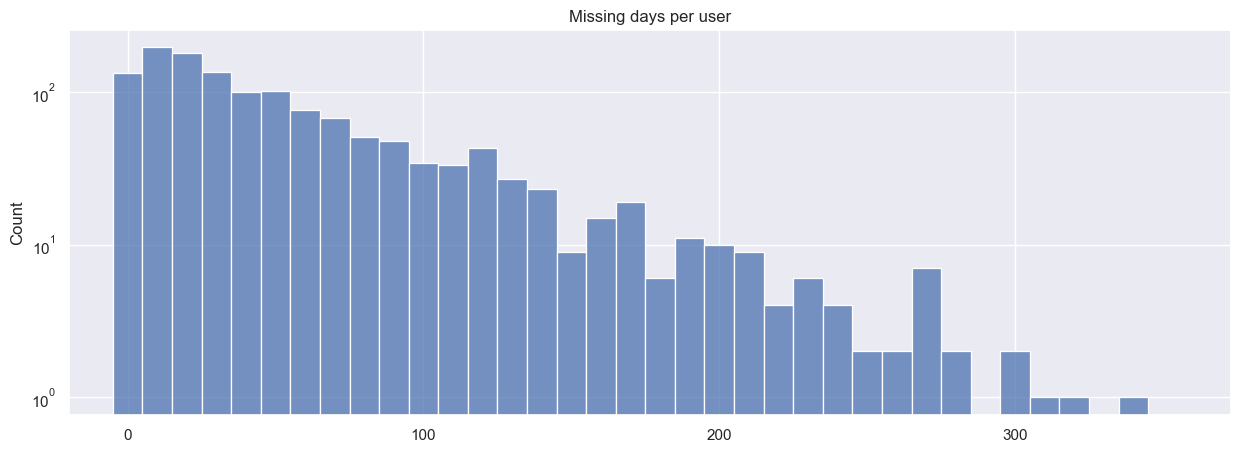

In [8]:
# histogram missing_months aligned on integer values
binwidth = 10
bin_heads = [i-binwidth/2 for i in range(0,2+int(missing_days.max()),binwidth)]
sns.histplot(missing_days, bins=bin_heads, log_scale=(False, True))
#enlarge the plot
plt.gcf().set_size_inches(15, 5)
plt.title("Missing days per user")
# align ticks with bin width
plt.xticks((np.array(bin_heads)+binwidth/2)[::10])
plt.xlim(missing_days.min()-2*binwidth, missing_days.max()+2*binwidth)
plt.show()

In [9]:
X_missing = X.copy().astype(float)

for user in range(X.shape[0]): 
    X_missing[user, :missing_days[user]] = np.nan

### Subsample the Dataset

Undersampling the dataset from both sides for quick prototyping.

In [10]:
USER_SUBSAMPLE_RATE, DAY_SUBSAMPLE_RATE = 1, 1
X, X_missing = X[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :], X_missing[::USER_SUBSAMPLE_RATE, ::DAY_SUBSAMPLE_RATE, :]
num_users, num_days, num_features = X.shape
X_gt_list = [X[user, :missing_days[user]]*1 for user in range(num_users)]

print("{:.<40}{:.>5}".format("Number of (subsampled/filtered) users", num_users))
print("{:.<40}{:.>5}".format("Number of (subsampled) days", num_days))
print("{:.<40}{:.>5}".format("Number of (aggregated) features", num_features))

Number of (subsampled/filtered) users....1364
Number of (subsampled) days...............730
Number of (aggregated) features............24


In [11]:
missing_idx_mat  = np.isnan(X_missing).any(2)
missing_num_labels = {"user": missing_idx_mat.sum(1), "day": missing_idx_mat.sum(0) }

In [12]:
X_missing = X_missing.reshape(-1, num_features)
missing_idx = np.isnan(X_missing.sum(1))
X_missing = X_missing[~missing_idx]

### Prepare the Training Data with Missing Records

#### Normalize

In [13]:
nonzero_mean, nonzero_std = utils.zero_preserved_log_stats(X_missing)
X_missing = utils.zero_preserved_log_normalize(X_missing, nonzero_mean, nonzero_std)

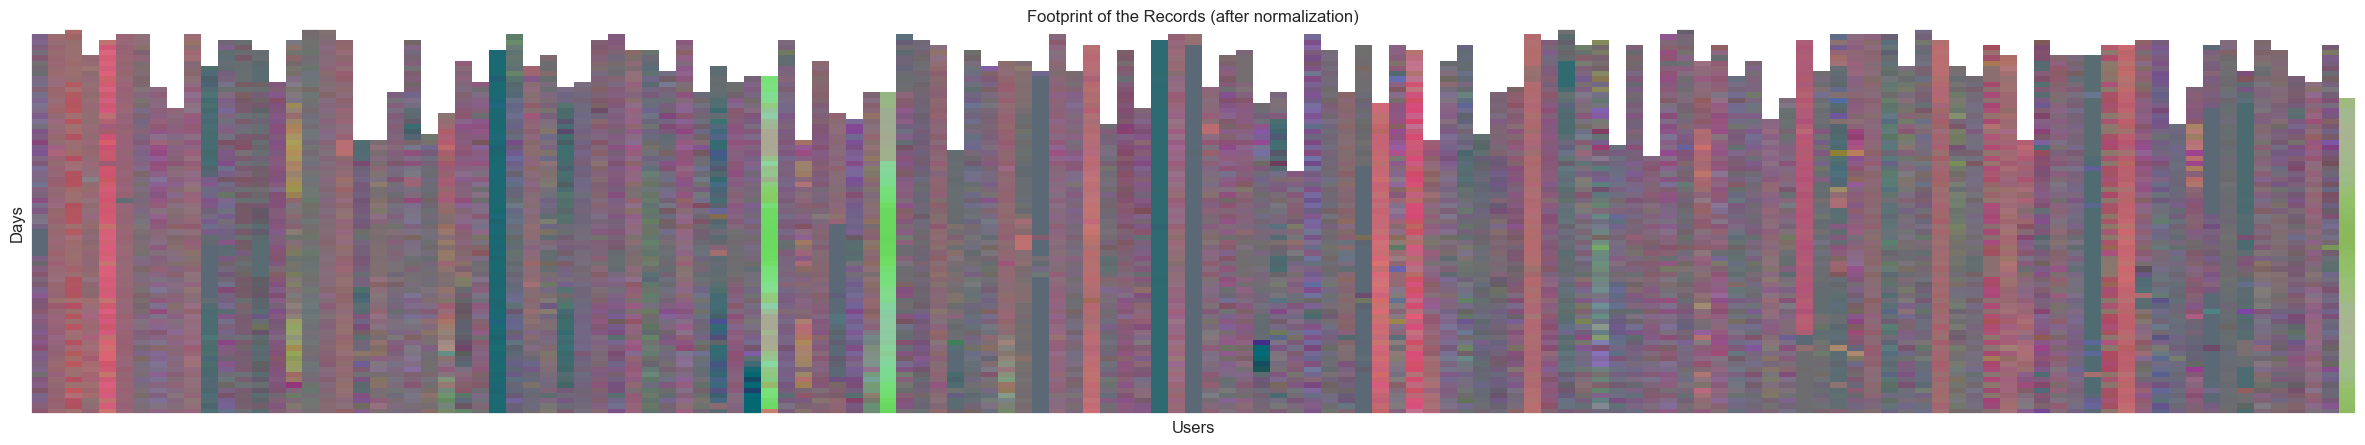

In [14]:
### reduce the dimensions to three
X_missing_rgb = np.ones((num_users*num_days, 3))
X_missing_rgb[~missing_idx] = PCA(n_components=3).fit_transform(X_missing)
X_missing_rgb[~missing_idx] = (X_missing_rgb[~missing_idx] - X_missing_rgb[~missing_idx].min(0)) / (X_missing_rgb[~missing_idx].max(0) - X_missing_rgb[~missing_idx].min(0))
X_missing_rgb = X_missing_rgb.reshape(num_users, num_days, 3)[::10,::10]


fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(X_missing_rgb.transpose(1,0,2), aspect='auto', interpolation='none')
ax.set_title('Footprint of the Records (after normalization)')
ax.set_ylabel('Days')
ax.set_xlabel('Users')
# remove ticks
ax.set_yticks([])
ax.set_xticks([])
plt.show()

#### Reduce Dimensionality

In [15]:
REDUCE_DIM = True
NUM_LOWER_DIM = 10
DECOMPOSER_NAME = 'SVD'

In [16]:
if DECOMPOSER_NAME == 'PCA': Decomposer = PCA
elif DECOMPOSER_NAME == 'kPCA': Decomposer = KernelPCA
elif DECOMPOSER_NAME == 'ICA': Decomposer = FastICA
elif DECOMPOSER_NAME == 'SVD': Decomposer = TruncatedSVD
else: raise ValueError(f'Unknown decomposer {DECOMPOSER_NAME}')

if REDUCE_DIM: 
    decomposer = Decomposer(n_components=NUM_LOWER_DIM).fit(X_missing)
else:
    NUM_LOWER_DIM = num_features
    decomposer = PCA(n_components=NUM_LOWER_DIM).fit(X_missing)
    decomposer.components_, decomposer.explained_variance_, decomposer.mean_ = np.eye(NUM_LOWER_DIM), np.ones(NUM_LOWER_DIM), np.zeros(NUM_LOWER_DIM)

X_missing = decomposer.transform(X_missing)

#### Cluster the Records

In [17]:
VOCAB_SIZE = 250
kmeans = KMeans(n_clusters=VOCAB_SIZE, random_state=RANDOM_SEED, init='k-means++', n_init='auto').fit(X_missing)
centers = datasets.zero_preserved_log_denormalize(decomposer.inverse_transform(kmeans.cluster_centers_), nonzero_mean, nonzero_std)

#### Assign the Words

In [18]:
labels = kmeans.labels_

labels_onehot = np.zeros((len(labels), len(set(labels))))
labels_onehot[np.arange(len(labels)), labels] = 1

#### Create Corpuses

In [19]:
X_words = np.zeros((num_users*num_days, VOCAB_SIZE))
X_words[~missing_idx] = labels_onehot
X_words = X_words.reshape(num_users, num_days, -1)
corpus_day, corpus_user = X_words.sum(axis=0), X_words.sum(axis=1)

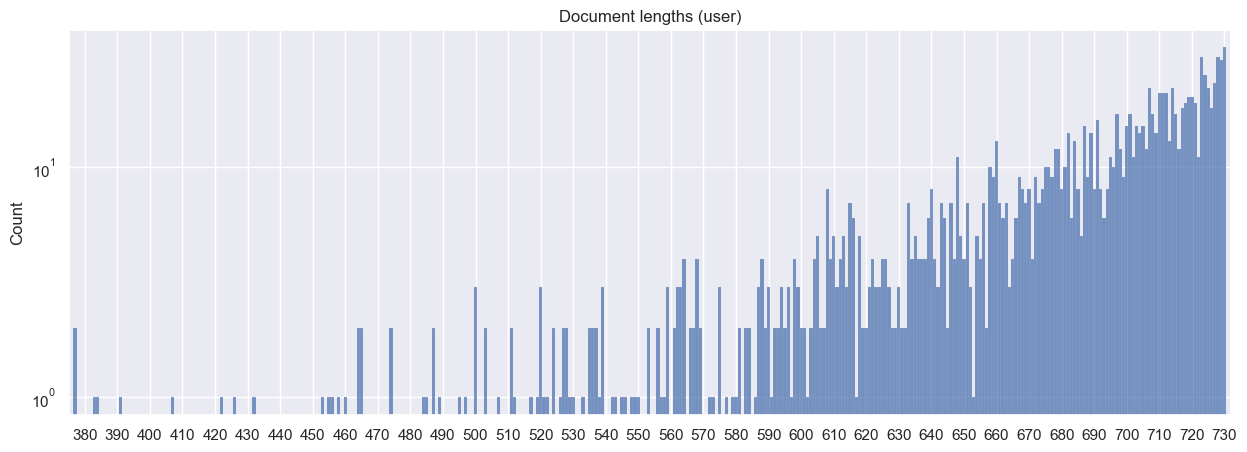

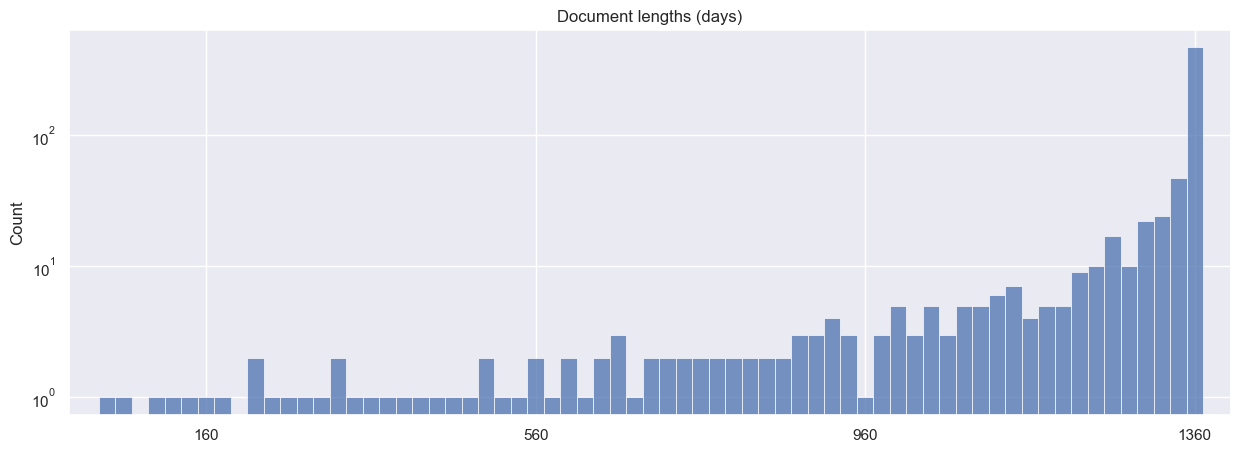

In [20]:
doc_lengths_user, doc_lengths_day = corpus_user.sum(axis=1), corpus_day.sum(axis=1)

binwidth = 1
# plot the histogram of document lengths on log scale using seaborn with bin width 100
bin_heads = [i+binwidth/2 for i in range(0,1+int(doc_lengths_user.max()),binwidth)]
sns.histplot(doc_lengths_user, bins=bin_heads, log_scale=(False, True))
plt.title("Document lengths (user)")
# align ticks with bin width
plt.xticks((np.array(bin_heads)-binwidth/2)[::-10][::-1])
plt.xlim(doc_lengths_user.min()-2*binwidth, doc_lengths_user.max()+2*binwidth)
plt.gcf().set_size_inches(15, 5)
plt.show()

binwidth = 20
# plot the histogram of document lengths on log scale using seaborn with bin width 100
bin_heads = [i+binwidth/2 for i in range(0,1+int(doc_lengths_day.max()),binwidth)]
sns.histplot(doc_lengths_day, bins=bin_heads, log_scale=(False, True))
plt.title("Document lengths (days)")
# align ticks with bin width
plt.xticks((np.array(bin_heads)-binwidth/2)[::-20][::-1])
plt.xlim(doc_lengths_day.min()-2*binwidth, doc_lengths_day.max()+2*binwidth)
plt.gcf().set_size_inches(15, 5)
plt.show()

### Train the Models

##### Global training parameters

In [21]:
NUM_TOPICS = 10
train_kwargs = {'doc_topic_prior': 1.0/NUM_TOPICS,  ## alpha
                'topic_word_prior': 1.0/VOCAB_SIZE, ## eta
                'perp_tol': 5e-2, 
                'max_iter': 100, ## number of epochs
                'batch_size': 64, 
                'verbose': True, 
                'learning_method': 'online', 
                'evaluate_every': 10}


#### Users as Documents

In [22]:
model_user = LDA(NUM_TOPICS, **train_kwargs).fit(corpus_user)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 60.1669
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 59.6745
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 59.5431
iteration: 31 of

In [23]:
lambda_user = model_user.components_
beta_mean_user = lambda_user / lambda_user.sum(axis=1, keepdims=True)
gamma_user = model_user._unnormalized_transform(corpus_user)
theta_mean_user = gamma_user / gamma_user.sum(axis=1, keepdims=True)

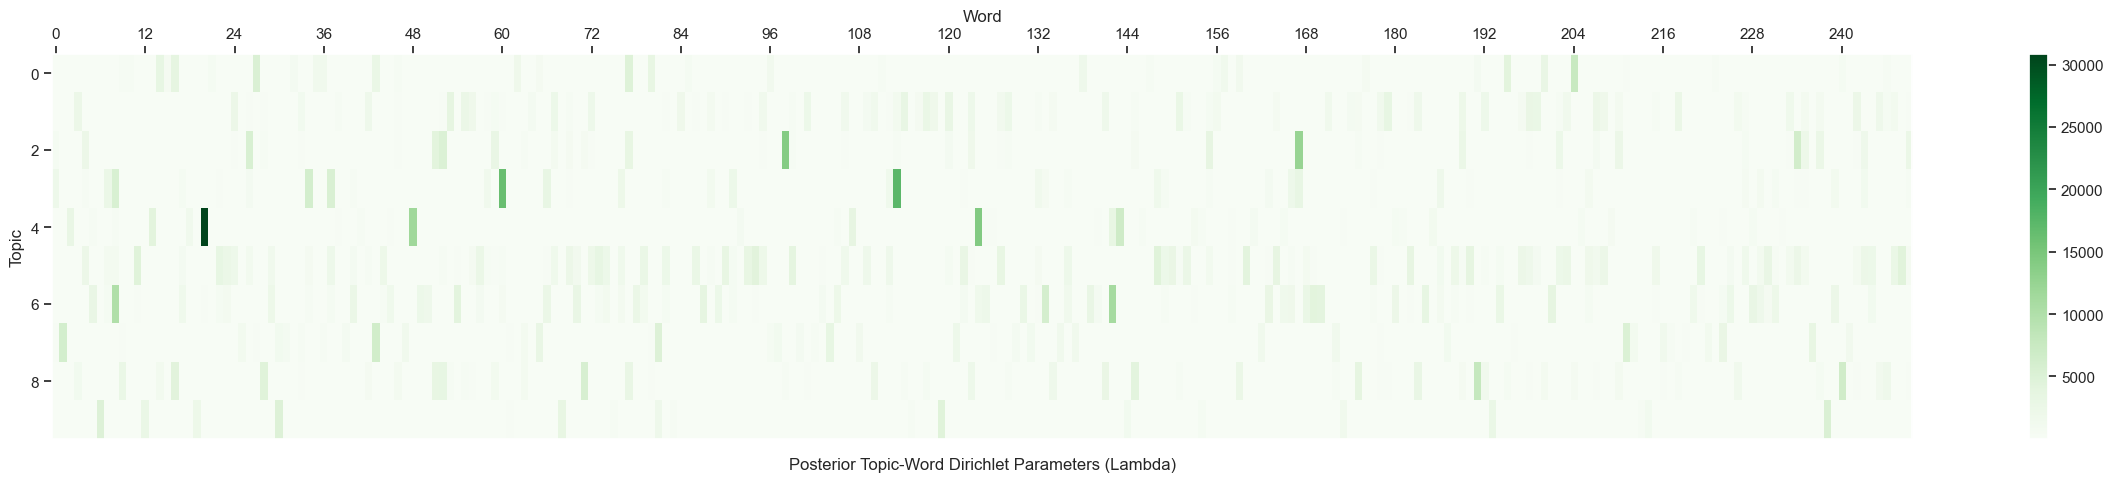

In [28]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(lambda_user, aspect='auto', cmap='Greens', interpolation='none')
ax.set_title('Posterior Topic-Word Dirichlet Parameters (Lambda)', y=-0.1)
ax.set_ylabel('Topic')
ax.set_xlabel('Word')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(VOCAB_SIZE))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, VOCAB_SIZE, VOCAB_SIZE//20))
fig.colorbar(im, ax=ax)
plt.show()

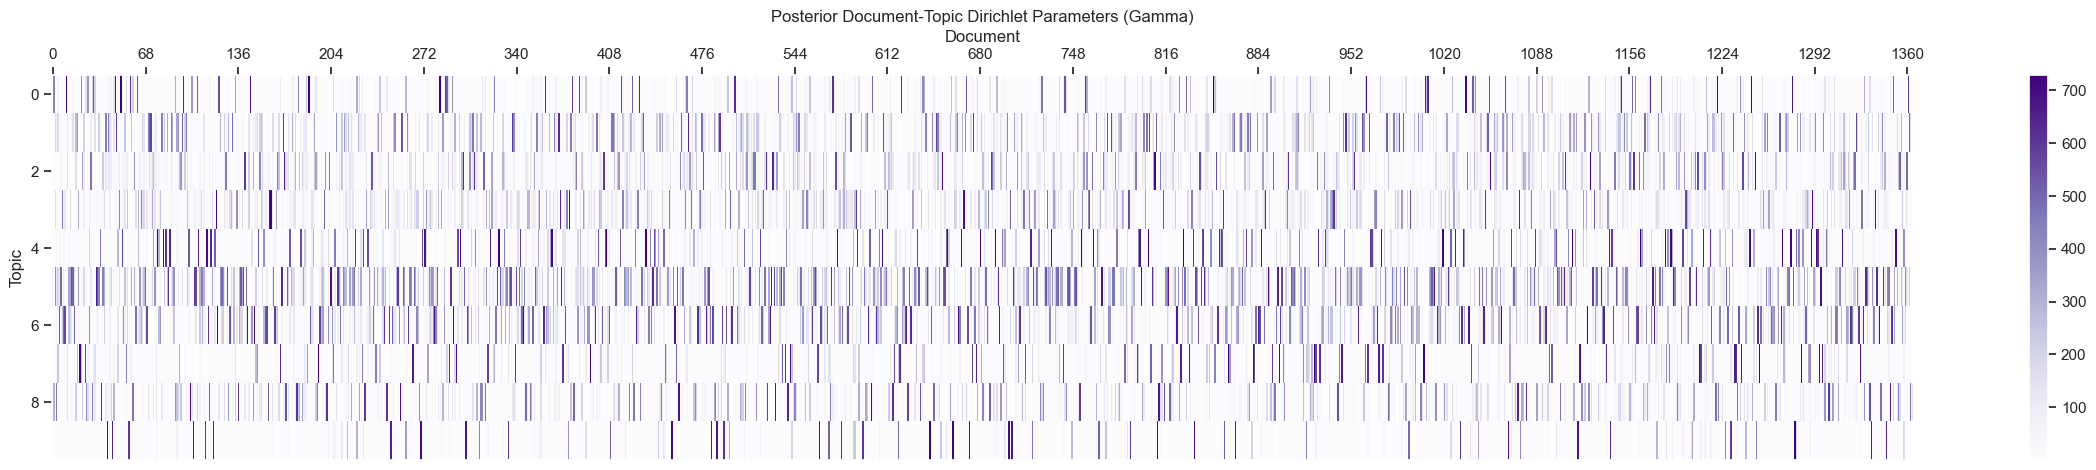

In [29]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(gamma_user.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(num_users))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, num_users, num_users//20))
fig.colorbar(im, ax=ax)
plt.show()

#### Days as Documents

In [30]:
model_day = LDA(NUM_TOPICS, **train_kwargs).fit(corpus_day)

iteration: 1 of max_iter: 100
iteration: 2 of max_iter: 100
iteration: 3 of max_iter: 100
iteration: 4 of max_iter: 100
iteration: 5 of max_iter: 100
iteration: 6 of max_iter: 100
iteration: 7 of max_iter: 100
iteration: 8 of max_iter: 100
iteration: 9 of max_iter: 100
iteration: 10 of max_iter: 100, perplexity: 169.6385
iteration: 11 of max_iter: 100
iteration: 12 of max_iter: 100
iteration: 13 of max_iter: 100
iteration: 14 of max_iter: 100
iteration: 15 of max_iter: 100
iteration: 16 of max_iter: 100
iteration: 17 of max_iter: 100
iteration: 18 of max_iter: 100
iteration: 19 of max_iter: 100
iteration: 20 of max_iter: 100, perplexity: 169.3670
iteration: 21 of max_iter: 100
iteration: 22 of max_iter: 100
iteration: 23 of max_iter: 100
iteration: 24 of max_iter: 100
iteration: 25 of max_iter: 100
iteration: 26 of max_iter: 100
iteration: 27 of max_iter: 100
iteration: 28 of max_iter: 100
iteration: 29 of max_iter: 100
iteration: 30 of max_iter: 100, perplexity: 169.2607
iteration: 31

In [31]:
lambda_day = model_day.components_
beta_mean_day = lambda_day / lambda_day.sum(axis=1, keepdims=True)
gamma_day = model_day._unnormalized_transform(corpus_day)
theta_mean_day = gamma_day / gamma_day.sum(axis=1, keepdims=True)

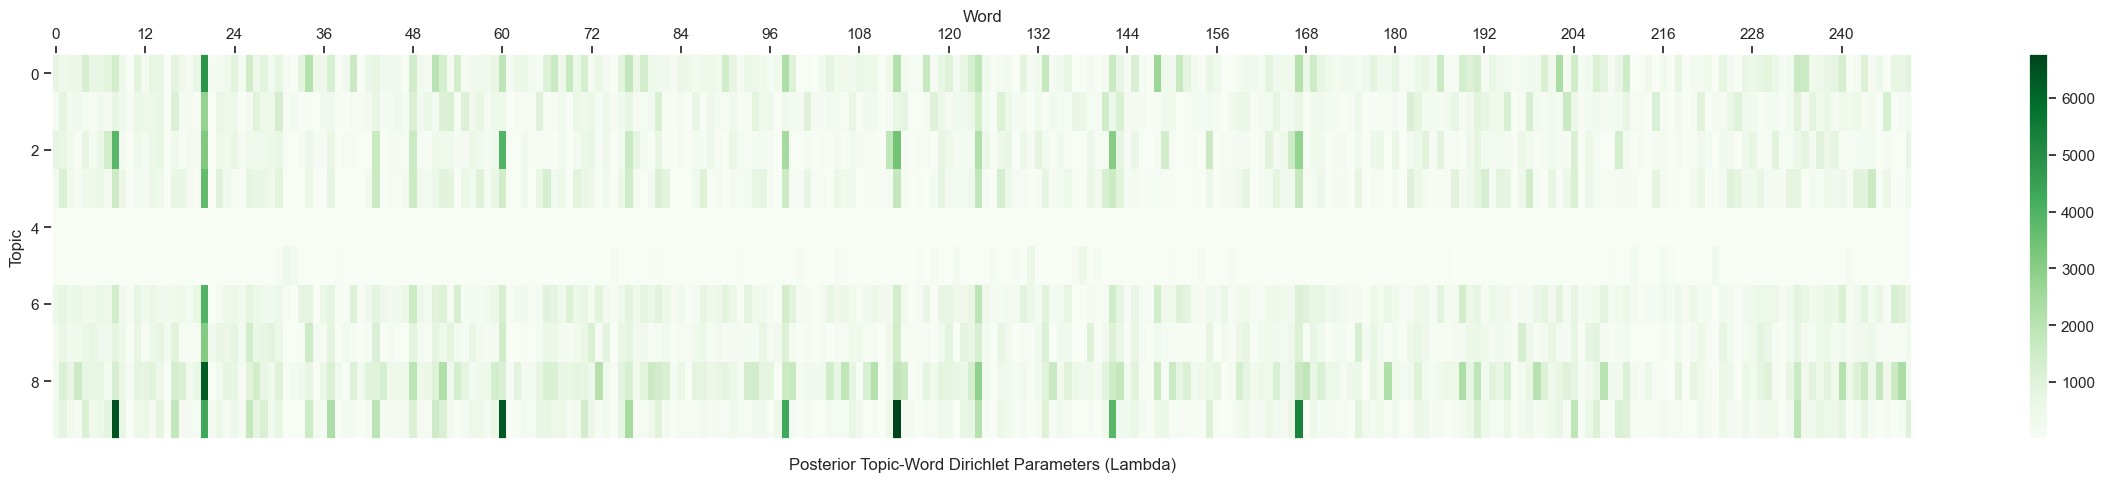

In [32]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(lambda_day, aspect='auto', cmap='Greens', interpolation='none')
ax.set_title('Posterior Topic-Word Dirichlet Parameters (Lambda)', y=-0.1)
ax.set_ylabel('Topic')
ax.set_xlabel('Word')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(VOCAB_SIZE))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, VOCAB_SIZE, VOCAB_SIZE//20))
fig.colorbar(im, ax=ax)
plt.show()

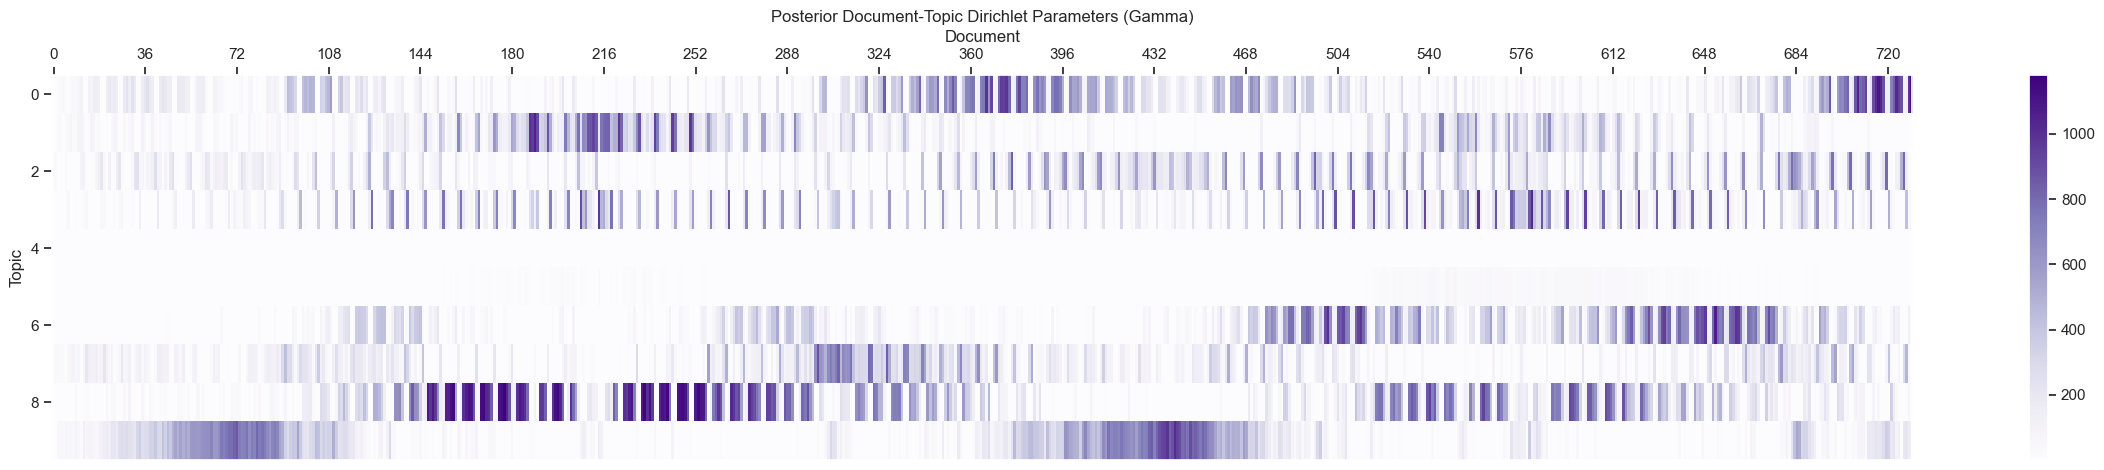

In [33]:
fig, ax = plt.subplots(figsize=(30,5))
im = ax.imshow(gamma_day.T, aspect='auto', cmap='Purples', interpolation='none')
ax.set_title('Posterior Document-Topic Dirichlet Parameters (Gamma)')
ax.set_ylabel('Topic')
ax.set_xlabel('Document')
ax.set_yticks(np.arange(NUM_TOPICS))
ax.set_xticks(np.arange(num_days))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
ax.xaxis.set_label_position('top')
ax.grid(False)
plt.yticks(np.arange(0, NUM_TOPICS, NUM_TOPICS//5))
plt.xticks(np.arange(0, num_days, num_days//20))
fig.colorbar(im, ax=ax)
plt.show()

### Ground Truths

In [34]:
gt_list = {}
gt_list["user"] = X_gt_list

gt_list["day"] = [ np.empty((0,24)).astype(int) for _ in range(num_days) ]
for user, day in product(range(num_users), range(num_days)):
    if gt_list["user"][user].shape[0] > 0 and gt_list["user"][user].shape[0] > day: 
        gt_list["day"][day] = np.concatenate([gt_list["day"][day], [gt_list["user"][user][day]]])

In [35]:
gt_labels_list = {}
## Ground truth label arrays of users (each element of the list is a user's label array)
gt_labels_list["user"] = [ np.array([]).astype(int) for _ in range(num_users) ]
for user, X_gt in enumerate(X_gt_list):
    if len(X_gt) > 0: gt_labels_list["user"][user] = kmeans.predict(decomposer.transform(utils.zero_preserved_log_normalize(X_gt*1.0, nonzero_mean, nonzero_std)))

## Ground truth label arrays of days (each element of the list is a day's label array)
gt_labels_list["day"] = [ np.array([]).astype(int) for _ in range(num_days) ]
for user, day in product(range(num_users), range(num_days)):
        if gt_labels_list["user"][user].size > 0 and gt_labels_list["user"][user].size > day: gt_labels_list["day"][day] = np.concatenate([gt_labels_list["day"][day], [gt_labels_list["user"][user][day]]])

In [36]:
average_gt_labels, empiric_dists = {}, {}

for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):
    average_gt_labels[doc_type] = [np.array([(word==gt_doc).sum()/gt_doc.size for word in gt_doc]) for gt_doc in gt_labels_list[doc_type]]
    empiric_dists[doc_type] = [ [] for _ in range(num_docs) ]
    for doc_no in range(num_docs):
        labels_ = gt_labels_list[doc_type][doc_no]
        labels_onehot_ = np.zeros((len(labels_), VOCAB_SIZE))
        labels_onehot_[np.arange(len(labels_)), labels_] = 1
        if labels_.size > 0: empiric_dists[doc_type][doc_no] = labels_onehot_.mean(0)

## Predictions

In [37]:
def next_word_probabilities(beta, theta, num_topics):
    if len(theta.shape) == 1: theta = theta.reshape(1, -1)
    if beta.shape[0] == num_topics: beta = beta.T
    return (beta[np.newaxis,:] * theta[:,np.newaxis,:]).sum(2)

In [38]:
next_word_probs = {"user": next_word_probabilities(beta_mean_user, theta_mean_user, NUM_TOPICS), "day": next_word_probabilities(beta_mean_day, theta_mean_day, NUM_TOPICS)}

In [39]:
loglikelihoods, perplexities, perplexity, class_metrics, class_metric, top_k_labels,cross_entropies, entropies, kl_divs = {}, {}, {}, {}, {}, {}, {}, {}, {}
reg_metrics, reg_metric = {}, {}

### Log-likelihood and Perplexities

In [40]:
for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):
    loglikelihoods[doc_type] = {"individual": [ np.log(next_word_probs[doc_type][doc_no][gt_labels_list[doc_type][doc_no]]) for doc_no in range(num_docs)]}
    loglikelihoods[doc_type]["total"] = np.array( [np.sum(loglikelihoods[doc_type]["individual"][doc_no]) for doc_no in range(num_docs)] )

    perplexities[doc_type] = np.exp( -loglikelihoods[doc_type]["total"] / missing_num_labels[doc_type])

    perplexity[doc_type] = np.exp( -np.sum(loglikelihoods[doc_type]["total"]) / np.sum(missing_num_labels[doc_type]) )

    print("{:.<30}{:.>5.3e}".format("Perplexity ("+doc_type+")", perplexity[doc_type]))
    print("-"*40)

Perplexity (user).............6.508e+01
----------------------------------------
Perplexity (day)..............1.533e+02
----------------------------------------


/tmp/ipykernel_101238/1313182660.py:5: RuntimeWarning: invalid value encountered in divide
  perplexities[doc_type] = np.exp( -loglikelihoods[doc_type]["total"] / missing_num_labels[doc_type])


### Top-k Predictions, Accuracies and Errors

In [41]:
K = [1, 3, 5]
for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):
    top_k_labels[doc_type] = {}
    for k in K: top_k_labels[doc_type][f"top{k}"] = [np.argsort(next_word_probs[doc_type][doc_no])[::-1][:k] for doc_no in range(num_docs)] 

In [42]:
vocab = np.arange(VOCAB_SIZE)

for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):

    class_metrics[doc_type] = {}
    class_metric[doc_type] = {}

    nwp_stacked = [next_word_probs[doc_type][doc_no][np.newaxis,:].repeat(missing_num_labels[doc_type][doc_no], axis=0) for doc_no in range(num_docs)]
    nwp_concat = np.concatenate(nwp_stacked)
    gt_concat = np.concatenate([gt_labels_list[doc_type][doc_no] for doc_no in range(num_docs)])
    for k in K:
        class_metrics[doc_type][f"top{k}"] = np.empty((num_docs,))
        for doc_no in range(num_docs):
            if missing_num_labels[doc_type][doc_no] > 0:
                class_metrics[doc_type][f"top{k}"][doc_no] = metrics.top_k_accuracy_score(gt_labels_list[doc_type][doc_no], nwp_stacked[doc_no], labels=vocab, k=k)
    # for k in K: accuracies[doc_type][f"top{k}"] = [np.isin(gt_labels_list[doc_type][doc_no], top_k_labels[doc_type][f"top{k}"][doc_no]).sum()/gt_labels_list[doc_type][doc_no].size for doc_no in range(num_docs)]
    
    
    class_metrics[doc_type]["conf_matrix"] = np.empty((num_docs,VOCAB_SIZE,VOCAB_SIZE))
    class_metrics[doc_type]["f1"] = {"micro":np.empty((num_docs,)), "macro":np.empty((num_docs,))}
    class_metrics[doc_type]["mcc"] = np.empty((num_docs,))
    for doc_no in range(num_docs):
        if missing_num_labels[doc_type][doc_no] > 0:
            labels_ = gt_labels_list[doc_type][doc_no]
            preds_ = np.argmax(nwp_stacked[doc_no], axis=1)
            class_metrics[doc_type]["conf_matrix"][doc_no] = metrics.confusion_matrix(labels_, preds_, labels=vocab)
            class_metrics[doc_type]["f1"]["micro"][doc_no] = metrics.f1_score(labels_, preds_, average='micro', labels=vocab, zero_division=np.nan)
            class_metrics[doc_type]["f1"]["macro"][doc_no] = metrics.f1_score(labels_, preds_, average='macro', labels=vocab, zero_division=np.nan)
            class_metrics[doc_type]["mcc"][doc_no] = metrics.matthews_corrcoef(labels_, preds_)

    print("-"*40)
    for k in K: 
        class_metric[doc_type][f"top{k}"] = metrics.top_k_accuracy_score(gt_concat, nwp_concat, labels=vocab, k=k)
        # class_metrics[doc_type][f"top{k}"] = np.sum([np.isin(gt_labels_list[doc_type][doc_no], top_k_labels[doc_type][f"top{k}"][doc_no]).sum() for doc_no in range(num_docs)]) / np.sum(missing_idx)
        print("{:.<35}{:.>5.4f}".format("Accuracy ("+f"top{k}"+") ("+doc_type+")", class_metric[doc_type][f"top{k}"]))
    
    class_metric[doc_type]["conf_matrix"] = metrics.confusion_matrix(gt_concat, np.argmax(nwp_concat, axis=1), labels=vocab)
    class_metric[doc_type]["f1"] = {"micro":metrics.f1_score(gt_concat, np.argmax(nwp_concat, axis=1), average='micro', labels=vocab), "macro":metrics.f1_score(gt_concat, np.argmax(nwp_concat, axis=1), average='macro', labels=vocab, zero_division=np.nan)}
    class_metric[doc_type]["mcc"] = metrics.matthews_corrcoef(gt_concat, np.argmax(nwp_concat, axis=1))

    print("{:.<35}{:.>5.4f}".format("F1 (micro) ("+doc_type+")", class_metric[doc_type]["f1"]["micro"]))
    print("{:.<35}{:.>5.4f}".format("F1 (macro) ("+doc_type+")", class_metric[doc_type]["f1"]["macro"]))
    print("{:.<35}{:.>5.4f}".format("MCC ("+doc_type+")", class_metric[doc_type]["mcc"]))

----------------------------------------
Accuracy (top1) (user).............0.0841
Accuracy (top3) (user).............0.1917
Accuracy (top5) (user).............0.2711
F1 (micro) (user)..................0.0841
F1 (macro) (user)..................0.0957
MCC (user).........................0.0702
----------------------------------------
Accuracy (top1) (day)..............0.0377
Accuracy (top3) (day)..............0.0900
Accuracy (top5) (day)..............0.1301
F1 (micro) (day)...................0.0377
F1 (macro) (day)...................0.0669
MCC (day)..........................0.0114


In [43]:
for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):

    reg_metrics[doc_type] = {}
    reg_metric[doc_type] = {}

    X_pred_list = [centers[top_k_labels[doc_type]["top1"][doc_no].repeat(missing_num_labels[doc_type][doc_no], axis=0)]  for doc_no in range(num_docs)]
    X_pred_concat = np.concatenate(X_pred_list)
    gt_concat = np.concatenate([gt_list[doc_type][doc_no] for doc_no in range(num_docs)])

    reg_metrics[doc_type]["mse"] = np.empty((num_docs,))
    reg_metrics[doc_type]["mae"] = np.empty((num_docs,))
    
    for doc_no in range(num_docs):
        if missing_num_labels[doc_type][doc_no] > 0:
            gts_ = gt_list[doc_type][doc_no]
            preds_ = X_pred_list[doc_no]
            reg_metrics[doc_type]["mse"][doc_no] = metrics.mean_squared_error(gts_, preds_)
            reg_metrics[doc_type]["mae"][doc_no] = metrics.mean_absolute_error(gts_, preds_)

    print("-"*40)
        
    reg_metric[doc_type]["mse"] = metrics.mean_squared_error(gt_concat, X_pred_concat)
    reg_metric[doc_type]["mae"] = metrics.mean_absolute_error(gt_concat, X_pred_concat)

    print("{:.<35}{:.>5.4f}".format("MSE ("+doc_type+")", reg_metric[doc_type]["mse"]))
    print("{:.<35}{:.>5.4f}".format("MAE ("+doc_type+")", reg_metric[doc_type]["mae"]))

----------------------------------------
MSE (user).........................897341.6458
MAE (user).........................246.2636
----------------------------------------
MSE (day)..........................940906.8132
MAE (day)..........................285.4733


### KL-Divergences

In [44]:
for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):
    cross_entropies[doc_type] = []
    entropies[doc_type] = []
    for doc_no in range(num_docs):
        if missing_num_labels[doc_type][doc_no]>0: cross_entropies[doc_type].append(-np.sum(empiric_dists[doc_type][doc_no]*np.log(next_word_probs[doc_type][doc_no]+1e-32)))
        else: cross_entropies[doc_type].append(np.nan)
        if missing_num_labels[doc_type][doc_no]>0: entropies[doc_type].append(-np.sum(empiric_dists[doc_type][doc_no]*np.log(empiric_dists[doc_type][doc_no]+1e-32)))
        else: entropies[doc_type].append(np.nan)
    
    kl_divs[doc_type] = np.array(cross_entropies[doc_type]) - np.array(entropies[doc_type])

## Visualize Results

### Perplexities

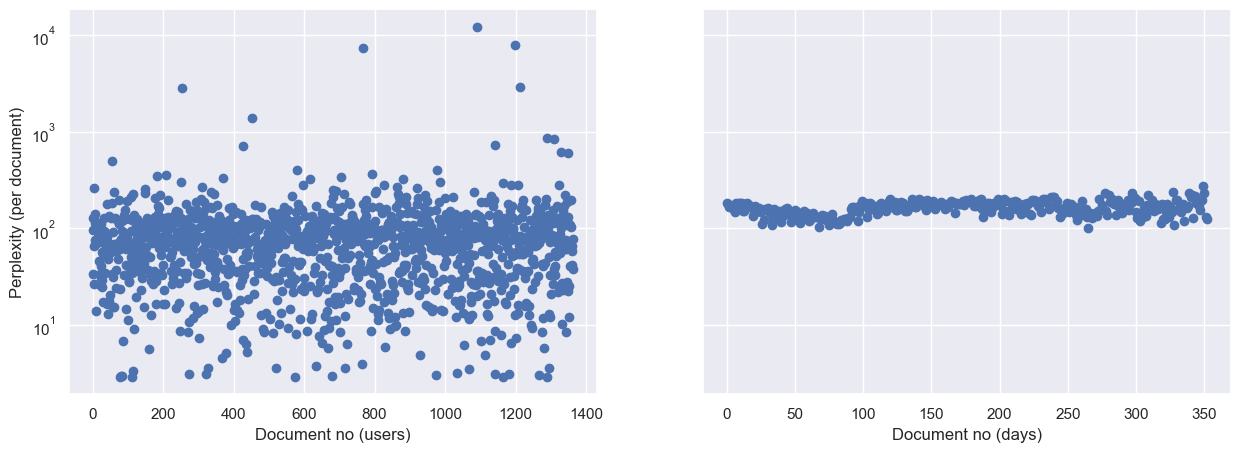

In [45]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
for i, (doc_type, num_docs) in enumerate(zip(["user", "day"], [num_users, num_days])):
    ax[i].scatter(np.arange(num_docs), perplexities[doc_type])
    ax[i].set_yscale('log')
    ax[i].set_xlabel(f'Document no ({doc_type}s)')
ax[0].set_ylabel(f"Perplexity (per document)")
plt.show()

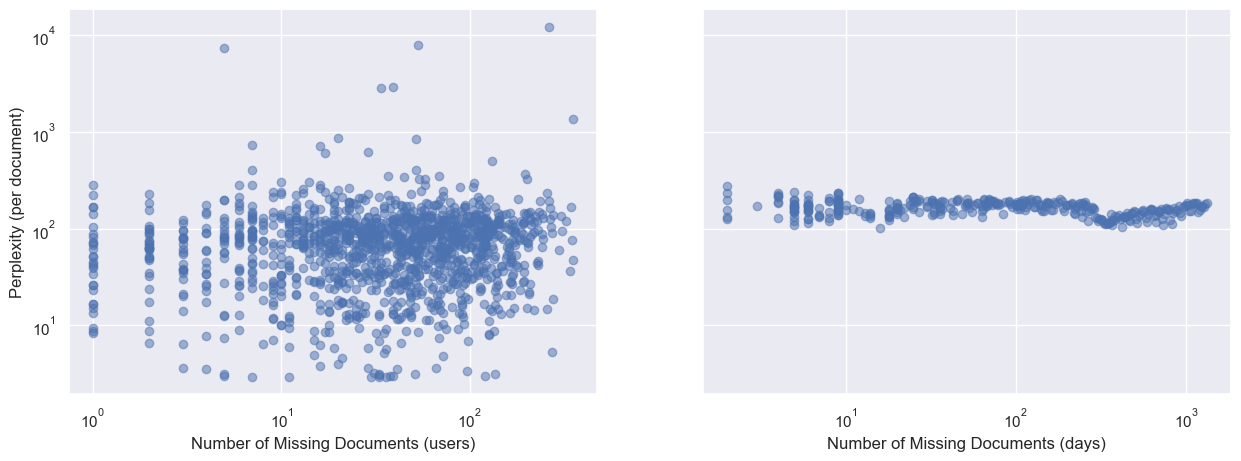

In [46]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
for i, (doc_type, num_docs) in enumerate(zip(["user", "day"], [num_users, num_days])):
    ax[i].scatter(missing_num_labels[doc_type], perplexities[doc_type], alpha=0.5)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel(f'Number of Missing Documents ({doc_type}s)')
ax[0].set_ylabel(f"Perplexity (per document)")
plt.show()

### KL-Divergences

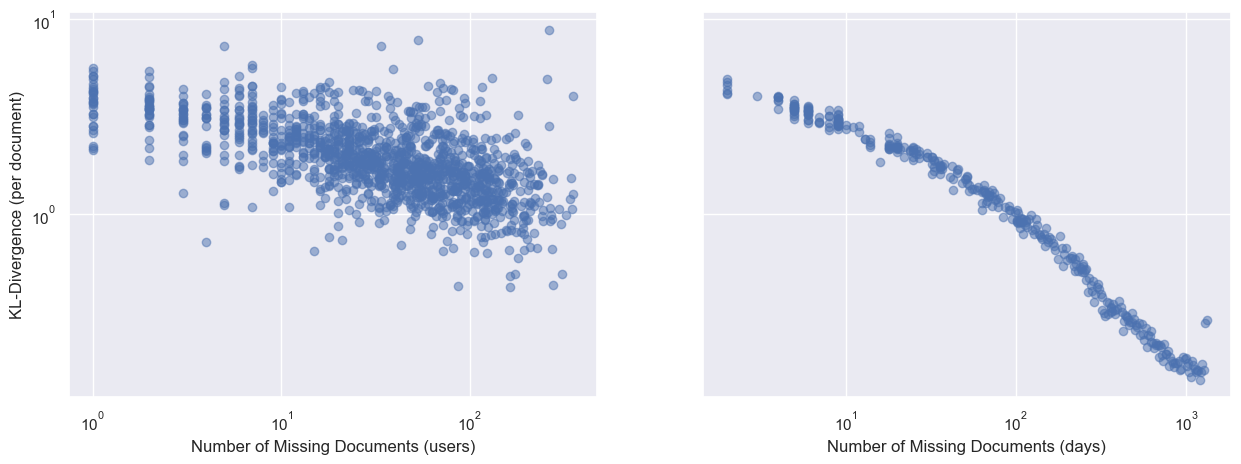

In [47]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
for i, (doc_type, num_docs) in enumerate(zip(["user", "day"], [num_users, num_days])):
    ax[i].scatter(missing_num_labels[doc_type], kl_divs[doc_type], alpha=0.5)
    ax[i].set_yscale('log')
    ax[i].set_xscale('log')
    ax[i].set_xlabel(f'Number of Missing Documents ({doc_type}s)')
ax[0].set_ylabel(f"KL-Divergence (per document)")
plt.show()

### Classification Metrics

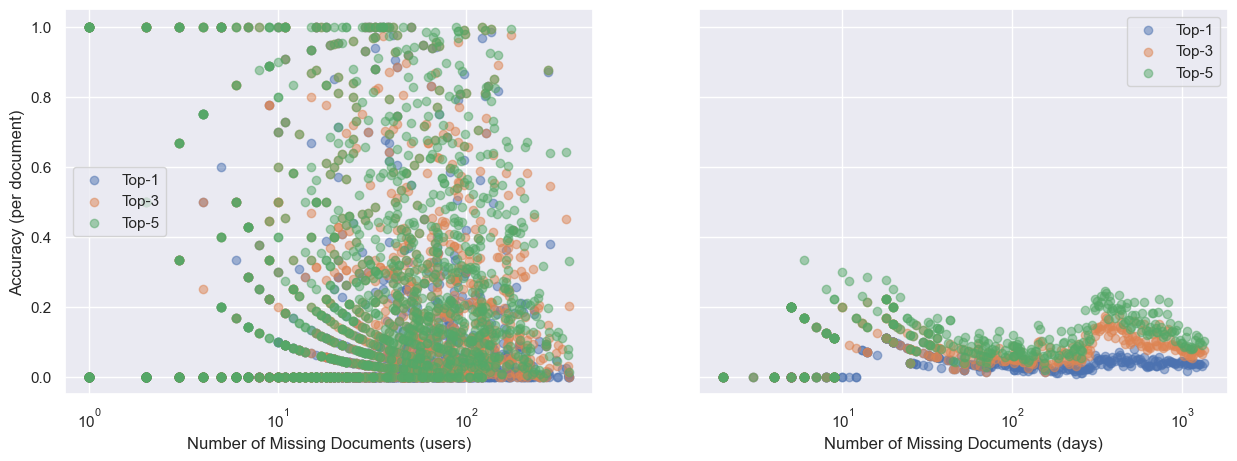

In [48]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
for k in K:
    for i, (doc_type, num_docs) in enumerate(zip(["user", "day"], [num_users, num_days])):
        ax[i].scatter(missing_num_labels[doc_type], class_metrics[doc_type][f"top{k}"], alpha=0.5, label=f"Top-{k}")
        ax[i].set_xlabel(f'Number of Missing Documents ({doc_type}s)')
        ax[i].legend()
        ax[i].set_xscale('log')
ax[0].set_ylabel(f"Accuracy (per document)")
plt.legend()
plt.show()

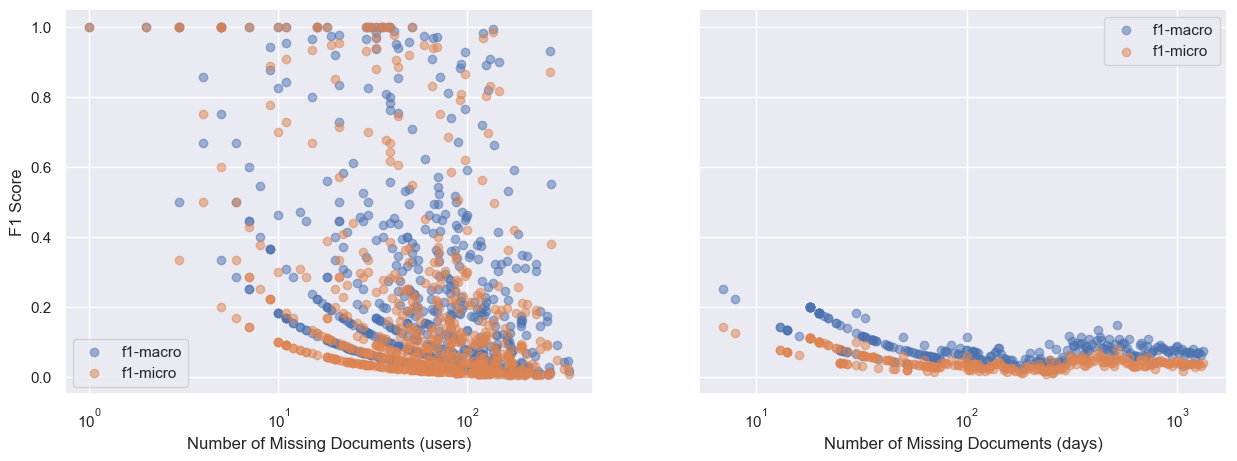

In [49]:
fig,ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
for i, (doc_type, num_docs) in enumerate(zip(["user", "day"], [num_users, num_days])):
    ax[i].scatter(missing_num_labels[doc_type], class_metrics[doc_type]["f1"]["macro"], label="f1-macro", alpha=0.5)
    ax[i].scatter(missing_num_labels[doc_type], class_metrics[doc_type]["f1"]["micro"], label="f1-micro", alpha=0.5)
    ax[i].set_xlabel(f'Number of Missing Documents ({doc_type}s)')
    ax[i].legend()
    ax[i].set_xscale('log')
ax[0].set_ylabel(f"F1 Score")
plt.show()

### Regression Metrics

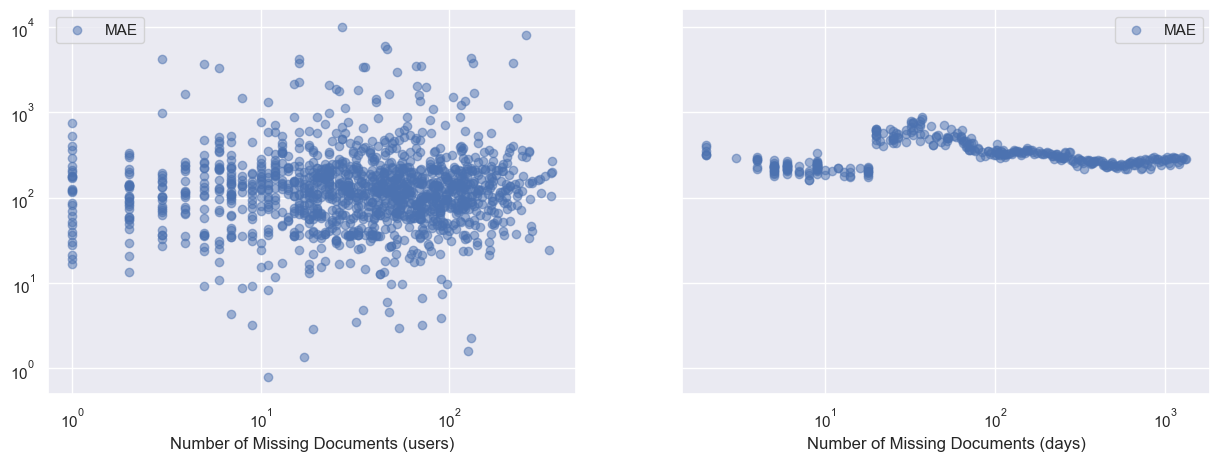

In [50]:
## regression metrics
fig,ax = plt.subplots(1,2,figsize=(15,5), sharey=True)
for i, (doc_type, num_docs) in enumerate(zip(["user", "day"], [num_users, num_days])):
    nonzero_mask = reg_metrics[doc_type]["mae"] > 0.1
    ax[i].scatter(missing_num_labels[doc_type][nonzero_mask], reg_metrics[doc_type]["mae"][nonzero_mask], alpha=0.5, label="MAE")
    ax[i].set_xlabel(f'Number of Missing Documents ({doc_type}s)')
    ax[i].legend()
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
plt.show()

## Joint Predictions

In [51]:
next_word_probs["joint"] = next_word_probs["user"][:,np.newaxis,:]*next_word_probs["day"][np.newaxis,:,:]
next_word_probs["joint"] = next_word_probs["joint"] / next_word_probs["joint"].sum(2, keepdims=True)

In [52]:
loglikelihoods["joint"] = {"individiual":[ [ np.log(next_word_probs["joint"][user][day][gt_labels_list["user"][user][day]]) for day in range(missing_num_labels["user"][user]) ] for user in range(num_users) ]}

loglikelihoods["joint"]["total"] = np.array([np.sum(loglikelihoods["joint"]["individiual"][user]) for user in range(num_users)])

perplexities["joint"] = np.exp( -loglikelihoods["joint"]["total"] / missing_num_labels["user"])

perplexity["joint"] = np.exp( -np.sum(loglikelihoods["joint"]["total"]) / np.sum(missing_num_labels["user"]) )

print("{:.<30}{:.>5.3e}".format("Perplexity (user)", perplexity["user"]))
print("-"*40)
print("{:.<30}{:.>5.3e}".format("Perplexity (day)", perplexity["day"]))
print("-"*40)
print("{:.<30}{:.>5.3e}".format("Perplexity (joint)", perplexity["joint"]))
print("-"*40)


Perplexity (user).............6.508e+01
----------------------------------------
Perplexity (day)..............1.533e+02
----------------------------------------
Perplexity (joint)............7.491e+01
----------------------------------------


/tmp/ipykernel_101238/3918098240.py:5: RuntimeWarning: invalid value encountered in divide
  perplexities["joint"] = np.exp( -loglikelihoods["joint"]["total"] / missing_num_labels["user"])


In [53]:
class_metrics["joint"] = {}
class_metric["joint"] = {}

nwp_stacked = [ [] for _ in range(num_users) ]
nwp_concat = []

for user in range(num_users):
    if missing_num_labels["user"][user] > 0:
        nwp_stacked[user] = np.array([ next_word_probs["joint"][user][day] for day in range(missing_num_labels["user"][user]) ] )
        nwp_concat.append(nwp_stacked[user])
nwp_concat = np.concatenate(nwp_concat)
gt_concat = np.concatenate([gt_labels_list["user"][user] for user in range(num_users)])

for k in K:
    class_metrics["joint"][f"top{k}"] = np.empty((num_users,))
    for user in range(num_users):
        if missing_num_labels["user"][user] > 0:
            class_metrics["joint"][f"top{k}"][user] = metrics.top_k_accuracy_score(gt_labels_list["user"][user], nwp_stacked[user], labels=vocab, k=k)

class_metrics["joint"]["conf_matrix"] = np.empty((num_users,VOCAB_SIZE,VOCAB_SIZE))
class_metrics["joint"]["f1"] = {"micro":np.empty((num_users,)), "macro":np.empty((num_users,))}
class_metrics["joint"]["mcc"] = np.empty((num_users,))
for user in range(num_users):
    if missing_num_labels["user"][user] > 0:
        labels_ = gt_labels_list["user"][user]
        preds_ = np.argmax(nwp_stacked[user], axis=1)
        class_metrics["joint"]["conf_matrix"][user] = metrics.confusion_matrix(labels_, preds_, labels=vocab)
        class_metrics["joint"]["f1"]["micro"][user] = metrics.f1_score(labels_, preds_, average='micro', labels=vocab, zero_division=np.nan)
        class_metrics["joint"]["f1"]["macro"][user] = metrics.f1_score(labels_, preds_, average='macro', labels=vocab, zero_division=np.nan)
        class_metrics["joint"]["mcc"][user] = metrics.matthews_corrcoef(labels_, preds_)

for k in K:
    class_metric["joint"][f"top{k}"] = metrics.top_k_accuracy_score(gt_concat, nwp_concat, labels=vocab, k=k)
    print("{:.<35}{:.>5.4f}".format("Accuracy ("+f"top{k}"+") (joint)", class_metric["joint"][f"top{k}"]))

class_metric["joint"]["conf_matrix"] = metrics.confusion_matrix(gt_concat, np.argmax(nwp_concat, axis=1), labels=vocab)
class_metric["joint"]["f1"] = {"micro":metrics.f1_score(gt_concat, np.argmax(nwp_concat, axis=1), average='micro', labels=vocab), "macro":metrics.f1_score(gt_concat, np.argmax(nwp_concat, axis=1), average='macro', labels=vocab, zero_division=np.nan)}
class_metric["joint"]["mcc"] = metrics.matthews_corrcoef(gt_concat, np.argmax(nwp_concat, axis=1))

print("{:.<35}{:.>5.4f}".format("F1 (micro) (joint)", class_metric["joint"]["f1"]["micro"]))
print("{:.<35}{:.>5.4f}".format("F1 (macro) (joint)", class_metric["joint"]["f1"]["macro"]))
print("{:.<35}{:.>5.4f}".format("MCC (joint)", class_metric["joint"]["mcc"]))

Accuracy (top1) (joint)............0.0859
Accuracy (top3) (joint)............0.2004
Accuracy (top5) (joint)............0.2802
F1 (micro) (joint).................0.0859
F1 (macro) (joint).................0.0697
MCC (joint)........................0.0696


In [54]:
for doc_type in ["user", "day"]:
    print("-"*40)
    for k in K: 
        print("{:.<35}{:.>5.4f}".format("Accuracy ("+f"top{k}"+") ("+doc_type+")", class_metric[doc_type][f"top{k}"]))

    print("{:.<35}{:.>5.4f}".format("F1 (micro) ("+doc_type+")", class_metric[doc_type]["f1"]["micro"]))
    print("{:.<35}{:.>5.4f}".format("F1 (macro) ("+doc_type+")", class_metric[doc_type]["f1"]["macro"]))
    print("{:.<35}{:.>5.4f}".format("MCC ("+doc_type+")", class_metric[doc_type]["mcc"]))

----------------------------------------
Accuracy (top1) (user).............0.0841
Accuracy (top3) (user).............0.1917
Accuracy (top5) (user).............0.2711
F1 (micro) (user)..................0.0841
F1 (macro) (user)..................0.0957
MCC (user).........................0.0702
----------------------------------------
Accuracy (top1) (day)..............0.0377
Accuracy (top3) (day)..............0.0900
Accuracy (top5) (day)..............0.1301
F1 (micro) (day)...................0.0377
F1 (macro) (day)...................0.0669
MCC (day)..........................0.0114


In [55]:
reg_metrics["joint"] = {}
reg_metric["joint"] = {}

X_pred_stacked = [ [] for _ in range(num_users) ]
X_pred_concat = []

for user in range(num_users):
    if missing_num_labels["user"][user] > 0:
        label_preds_ = np.argmax(nwp_stacked[user])
        X_pred_stacked[user] = centers[np.argmax(nwp_stacked[user], axis=1)]
        X_pred_concat.append(X_pred_stacked[user])
X_pred_concat = np.concatenate(X_pred_concat)
gt_concat = np.concatenate([gt_list["user"][user] for user in range(num_users)])

reg_metrics["joint"]["mse"] = np.empty((num_users,))
reg_metrics["joint"]["mae"] = np.empty((num_users,))

for user in range(num_users):
    if missing_num_labels["user"][user] > 0:
        gts_ = gt_list["user"][user]
        preds_ = X_pred_stacked[user]
        reg_metrics["joint"]["mse"][user] = metrics.mean_squared_error(gts_, preds_)
        reg_metrics["joint"]["mae"][user] = metrics.mean_absolute_error(gts_, preds_)

print("-"*40)
    
reg_metric["joint"]["mse"] = metrics.mean_squared_error(gt_concat, X_pred_concat)
reg_metric["joint"]["mae"] = metrics.mean_absolute_error(gt_concat, X_pred_concat)

print("{:.<35}{:.>5.4f}".format("MSE ("+"joint"+")", reg_metric["joint"]["mse"]))
print("{:.<35}{:.>5.4f}".format("MAE ("+"joint"+")", reg_metric["joint"]["mae"]))



----------------------------------------
MSE (joint)........................714076.4206
MAE (joint)........................238.4859


In [56]:
for doc_type, num_docs in zip(["user", "day"], [num_users, num_days]):
    print("-"*40)

    print("{:.<35}{:.>5.4f}".format("MSE ("+doc_type+")", reg_metric[doc_type]["mse"]))
    print("{:.<35}{:.>5.4f}".format("MAE ("+doc_type+")", reg_metric[doc_type]["mae"]))

----------------------------------------
MSE (user).........................897341.6458
MAE (user).........................246.2636
----------------------------------------
MSE (day)..........................940906.8132
MAE (day)..........................285.4733


### Individiual Inspections

In [57]:
# USER_NO = 395
# DAY_NO = 170

USER_NO = 500
DAY_NO = 10

# if missing_num_days[USER_NO]<DAY_NO:
#     DAY_NO = missing_num_days[USER_NO]
#     print(f"User {USER_NO} has {missing_num_days[USER_NO]} missing days. DAY_NO is set to {missing_num_days[USER_NO]}")

if not np.isin(USER_NO, np.where(missing_idx_mat[:,DAY_NO])):
    USER_NO = np.where(missing_idx_mat[:,DAY_NO])[0][0]
    print(f"User {USER_NO} is not missing on day {DAY_NO}. USER_NO is set to {USER_NO}")


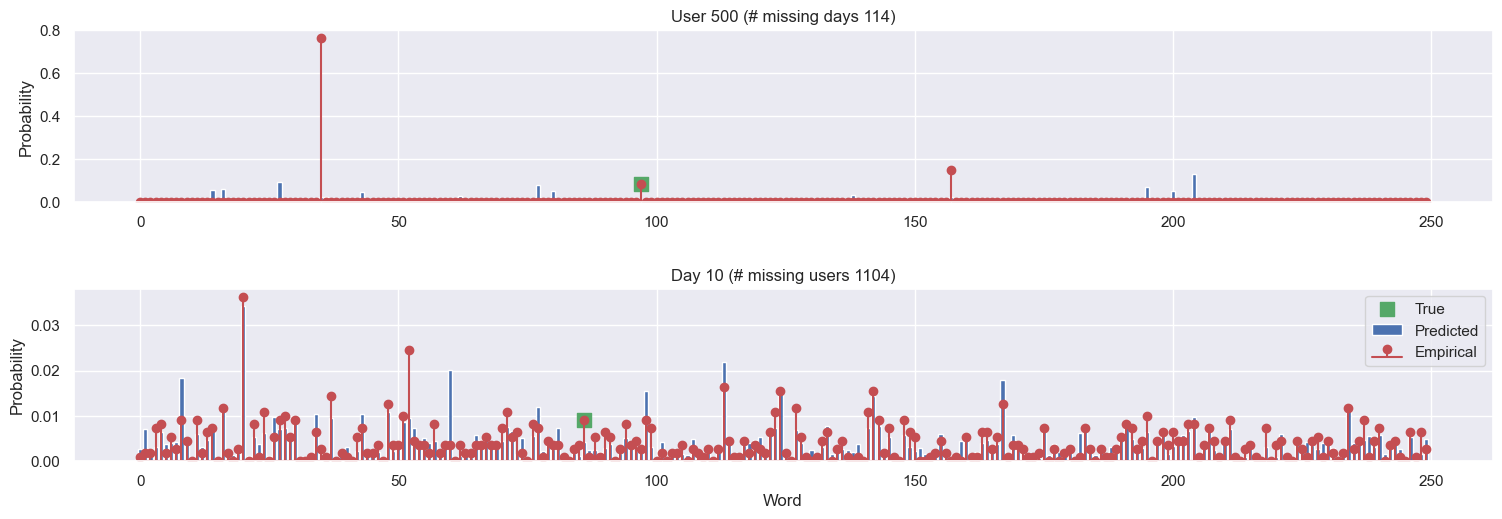

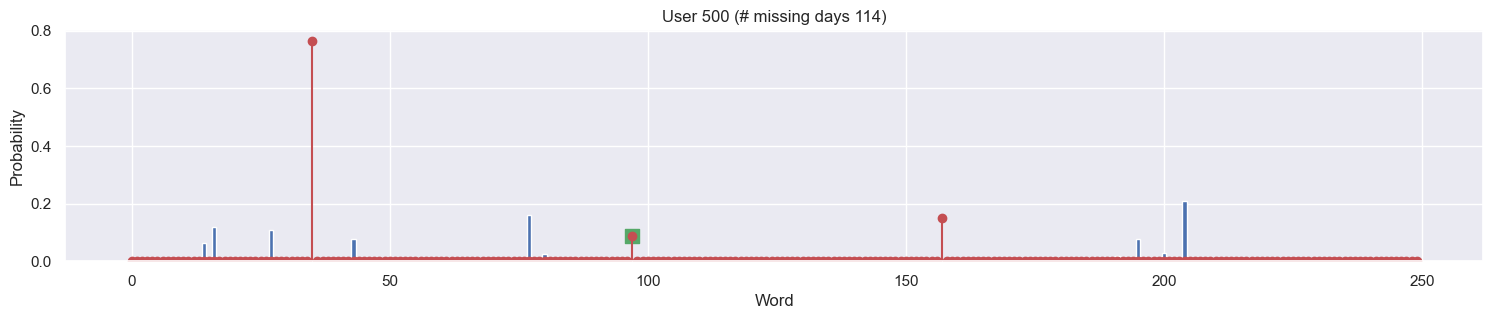

In [58]:
fig, ax = plt.subplots(2,1,figsize=(15,5))
fig.tight_layout()
# increase the space between plots
plt.subplots_adjust(hspace=0.5)
for i, (doc_type, doc_no) in enumerate(zip(["user", "day"], [USER_NO, DAY_NO])):
    ax[i].bar(np.arange(VOCAB_SIZE), next_word_probs[doc_type][doc_no], label="Predicted")
    ax[i].stem(np.arange(VOCAB_SIZE), empiric_dists[doc_type][doc_no], label="Empirical", linefmt='r-', markerfmt='ro', basefmt='r-')
    # mark the true label
    ax[i].set_ylabel("Probability")
ax[1].set_xlabel("Word")
ax[0].scatter(gt_labels_list["user"][USER_NO][DAY_NO], empiric_dists["user"][USER_NO][gt_labels_list["user"][USER_NO][DAY_NO]], color='g', label="True", s=100, marker='s')
ax[1].scatter(gt_labels_list["day"][DAY_NO][0], empiric_dists["day"][DAY_NO][gt_labels_list["day"][DAY_NO][0]], color='g', label="True", s=100, marker='s')
ax[0].set_title(f"User {USER_NO} (# missing days {missing_num_labels['user'][USER_NO]})")
ax[1].set_title(f"Day {DAY_NO} (# missing users {missing_num_labels['day'][DAY_NO]})")
ax[1].legend()
plt.show()

fig, ax = plt.subplots(1, 1,figsize=(18.3,3))
# fig.tight_layout()
ax.bar(np.arange(VOCAB_SIZE), next_word_probs["joint"][USER_NO][DAY_NO], label="Predicted")
ax.stem(np.arange(VOCAB_SIZE), empiric_dists["user"][USER_NO], label="Empirical", linefmt='r-', markerfmt='ro', basefmt='r-')
# mark the true label
ax.set_xlabel("Word")
ax.scatter(gt_labels_list["user"][USER_NO][DAY_NO], empiric_dists["user"][USER_NO][gt_labels_list["user"][USER_NO][DAY_NO]], color='g', label="True", s=100, marker='s')
ax.set_title(f"User {USER_NO} (# missing days {missing_num_labels['user'][USER_NO]})")
# ax.legend()
ax.set_ylabel("Probability")
plt.show()

In [59]:
print("{:.<35}{:.>5.4f}".format("Perplexity of the user "+f"{USER_NO}:", perplexities['user'][USER_NO]))
print("{:.<35}{:.>5.4f}".format("KL-Divergence of the user "+f"{USER_NO}:", kl_divs['user'][USER_NO]))
print("{:.<35}{:.>5.4f}".format("Accuracy of the user "+f"{USER_NO}:", class_metrics['user']['top1'][USER_NO]))

print("-"*40)

print("{:.<35}{:.>5.4f}".format("Perplexity of the day "+f"{DAY_NO}:", perplexities['day'][DAY_NO]))
print("{:.<35}{:.>5.4f}".format("KL-Divergence of the day "+f"{DAY_NO}:", kl_divs['day'][DAY_NO]))
print("{:.<35}{:.>5.4f}".format("Accuracy of the day "+f"{DAY_NO}:", class_metrics['day']['top1'][DAY_NO]))

print("-"*40)

print("{:.<35}{:.>5.4f}".format("Perplexity of the joint "+f"{USER_NO}:", perplexities['joint'][USER_NO]))
print("{:.<35}{:.>5.4f}".format("Accuracy of the joint "+f"{USER_NO}:", class_metrics['joint']['top1'][USER_NO]))

Perplexity of the user 500:........92.3035
KL-Divergence of the user 500:.....3.8216
Accuracy of the user 500:..........0.0000
----------------------------------------
Perplexity of the day 10:..........183.7416
KL-Divergence of the day 10:.......0.1659
Accuracy of the day 10:............0.0362
----------------------------------------
Perplexity of the joint 500:.......376.7989
Accuracy of the joint 500:.........0.0000


In [60]:
        self.doc_topic_prior = doc_topic_prior
        self.topic_word_prior = topic_word_prior

NameError: name 'doc_topic_prior' is not defined

In [ ]:
num_users*model_user.doc_topic_prior

136.4

In [ ]:
gamma_user.sum(0) + num_users*model_user.doc_topic_prior + model_user.topic_word_prior

array([ 14897.84256475, 116702.65171594, 208113.55490118, 158467.2673136 ,
       105364.02855899,  69115.82604215,  41465.70807217,  88328.19757511,
        58182.61783086,  57890.40542524])

In [ ]:
lambda_user